In [443]:
import json
import operator

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import src.utils as cutil

f_in = cutil.DATA_RAW / "multi_country" / "policy_implication_rules.json"
operator_map = {">": operator.gt, ">=": operator.ge, "=": operator.eq}

short_names_policy = {
    "Business Closure": "BC",
    "Event Cancel": "EC",
    "No Gathering": "NG",
    "Religious Closure": "RC",
    "Work From Home": "WFH",
    "Home Isolation": "HI",
    "No Gathering Inside": "NG-In",
    "Social Distance": "SD",
    "School Closure": "SC",
    "Pos Cases Quarantine": "PCQ",
    "Travel Ban Local": "TB-L",
}

short_names_subpolicy = {
    "Opt All Non-Essentials": "Opt",
    "All Non-Essentials": "Mand",
    "Cancel More Than One Event": "",
    "Advisory": "Opt",
    "No Gathering": "Mand",
    "Religious Closure - Optional": "",
    "School Closure": "",
    "Opt Work From Home": "Opt",
    "Work From Home": "Mand",
    "Opt Shelter In Place": "Opt",
    "Mandatory Shelter In Place": "Mand",
}

sns.set(context="paper", style="white")

In [444]:
with open(f_in, "r") as f:
    rel = json.load(f)

# drop countries with no implications
rel = {k: v for k, v in rel.items() if v != []}

In [474]:
def prettify_policies(df, index_level=None):
    def _prettify(x):
        return x.title().replace("_", " ")

    df = df.rename(columns=_prettify)
    df = df.rename(index=_prettify, level=index_level)
    return df


def order_us(df):
    index_order = [
        ("Home Isolation", "Opt Shelter In Place"),
        ("Home Isolation", "Mandatory Shelter In Place"),
        ("No Gathering", "No Gathering"),
    ]
    column_order = [
        ("Business Closure", "Opt All Non-Essentials"),
        ("Business Closure", "All Non-Essentials"),
        ("Event Cancel", "Cancel More Than One Event"),
        ("No Gathering", "Advisory"),
        ("No Gathering", "No Gathering"),
        ("Religious Closure", "Religious Closure - Optional"),
        ("School Closure", "School Closure"),
        ("Work From Home", "Opt Work From Home"),
        ("Work From Home", "Work From Home"),
    ]
    out = df.reindex(
        index=pd.MultiIndex.from_tuples(index_order, names=["Policy", "Category"]),
        columns=pd.MultiIndex.from_tuples(
            column_order, names=["Implied Policy", "Category"]
        ),
    )

    # make sure we got all the columns
    assert out.shape == df.shape
    return out


def get_heatmap_data_usa(rel):

    # get policy relationships for this country
    this_rel = rel["USA"]

    # get source vars, source intensity vals, and targ vars
    srcs = set(this_rel.keys())
    srcs = [i.split(".") for i in srcs]
    targs = set(sum(this_rel.values(), []))
    targs = [i.split(".") for i in targs]

    out_df = (
        pd.DataFrame(
            0,
            index=pd.MultiIndex.from_tuples(srcs),
            columns=pd.MultiIndex.from_tuples(targs),
        )
        .sort_index()
        .sort_index(axis=1)
    )

    for k, v in this_rel.items():
        ix = k.split(".")
        for targ in v:
            c = targ.split(".")
            out_df.loc[tuple(ix), tuple(c)] = 1

    return out_df


def get_heatmap_data(rel, iso):

    # get policy relationships for this country
    this_rel = rel[iso]

    # load policy data
    policy_sheet = pd.read_csv(
        cutil.DATA_RAW / cutil.iso_to_dirname(iso) / f"{iso}_policy_data_sources.csv"
    )

    # some countries have no intensity-weighting
    if "policy_intensity" not in policy_sheet.columns:
        policy_sheet["policy_intensity"] = 1

    # get source vars, source intensity vals, and targ vars
    srcs = set([i[0] for i in this_rel])
    targs = set([j[0] for j in sum([i[3] for i in this_rel], [])])
    src_vals = {
        k: policy_sheet.loc[policy_sheet.policy == k, "policy_intensity"].unique()
        for k in srcs
    }

    # get mapping from src/intensity to intensity of each targ
    rel_map = {}
    for r in this_rel:
        src = r[0]
        op = operator_map[r[1]]
        comp_val = r[2]

        this_src_vals = src_vals[src]
        for v in this_src_vals:
            if op(v, comp_val):
                this_map_targ = rel_map.get((src, v), [])
                this_map_targ += r[3]
                rel_map[(src, v)] = this_map_targ

    # convert to dataframe
    out_df = (
        pd.DataFrame(0, index=rel_map.keys(), columns=targs)
        .sort_index()
        .sort_index(axis=1)
    )
    for k, v in rel_map.items():
        for mapping in v:
            out_df.loc[k, mapping[0]] = mapping[1]

    out_df.index.names = ["Policy", "Intensity"]
    out_df.columns.name = "Implied Policy"

    return out_df


def add_line(ax, xpos, ypos, axis):
    if axis == 1:
        line_locs = [[xpos, xpos], [ypos + 0.1, ypos]]
    else:
        line_locs = [[ypos + 0.1, ypos], [1 - xpos, 1 - xpos]]
    line = plt.Line2D(*line_locs, transform=ax.transAxes, color="gray")
    line.set_clip_on(False)
    ax.add_line(line)


def label_axis(ax, df, axis):

    if axis == 1:
        ix = df.columns
        df = df.T
    elif axis == 0:
        ix = df.index
    else:
        raise ValueError(axis)
    ypos = -0.1

    loc_mapping_1 = pd.Series(1, index=ix.get_level_values(1))
    loc_mapping_0 = df.groupby(level=0).count().iloc[:, 0]

    for lx, loc_mapping in enumerate([loc_mapping_1, loc_mapping_0]):
        if lx == 0:
            rotation = 90
            ha = "center"
            rotation_mode = "default"
        else:
            rotation = 0
            ha = "center"
            rotation_mode = "default"
        total_len = loc_mapping.sum()
        line_width = loc_mapping / 2 / total_len
        xpos = loc_mapping.cumsum() / total_len - line_width
        for ix in range(xpos.index.size):
            if axis == 1:
                text_loc = (xpos.iloc[ix], ypos)
            else:
                text_loc = (ypos, 1 - xpos.iloc[ix])
            label = xpos.index[ix]
            ax.text(
                *text_loc,
                label,
                transform=ax.transAxes,
                rotation=rotation,
                ha=ha,
                rotation_mode=rotation_mode,
            )
            add_line(ax, xpos.iloc[ix] + line_width.iloc[ix], ypos, axis)
        add_line(ax, 0, ypos, axis)
        ypos -= 0.1
    return ax

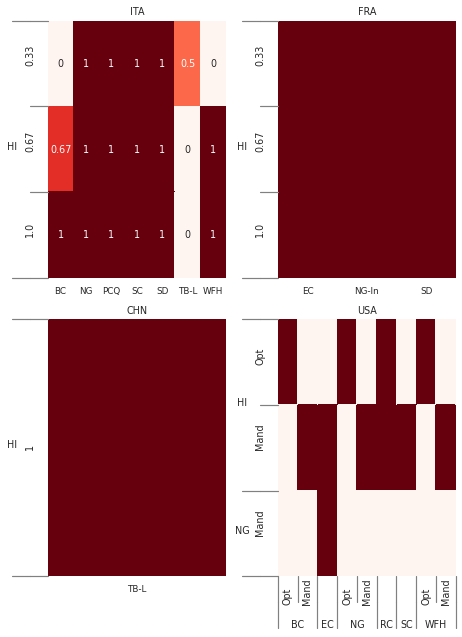

In [480]:
fig, axs = plt.subplots(2, 2, figsize=(6.5, 9), dpi=None, tight_layout=True)

for ix, iso in enumerate(rel.keys()):

    # get axis
    ax = axs.flatten()[ix]

    # get data
    if iso == "USA":
        out_df = order_us(prettify_policies(get_heatmap_data_usa(rel)))
        out_df = out_df.rename(
            columns=short_names_subpolicy, level=1, index=short_names_subpolicy
        )
    else:
        out_df = prettify_policies(get_heatmap_data(rel, iso), index_level=0)
        out_df.index.names = ["Policy", "Intensity"]

    # fix up column/row names
    out_df = out_df.rename(
        columns=short_names_policy, level=0, index=short_names_policy
    )

    if ((out_df != 1) & (out_df != 0)).any().any():
        annot = True
    else:
        annot = False
    # plot
    ax = sns.heatmap(
        out_df, annot=annot, cmap="Reds", vmin=0, vmax=1, cbar=False, ax=ax
    )
    ax.set_title(iso)
    ax.set_yticklabels("")
    ax.set_ylabel("")
    label_axis(ax, out_df, 0)

    ax.set_xlabel("")
    if iso == "USA":
        ax.set_xticklabels("")
        label_axis(ax, out_df, 1)